In [1]:
import os
import calendar
from google.cloud import bigquery
from google.oauth2 import service_account
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from pandas.api.types import CategoricalDtype

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "iowa-liquor-sales-446902-e270ede3516f.json"
credentials = service_account.Credentials.from_service_account_file('iowa-liquor-sales-446902-e270ede3516f.json')

In [3]:
client = bigquery.Client()

In [4]:
def query_to_dataframe(query: str):
    """
    Executes a SQL query using Google BigQuery client and returns the result as a Pandas DataFrame.

    Args:
    - query (str): SQL query string to be executed.

    Returns:
    - pd.DataFrame: Result of the SQL query in the form of a Pandas DataFrame.
    """
    return client.query(query).to_dataframe()

Let's check data types for all available columns

In [5]:
schema_info_query = """
SELECT column_name, data_type
FROM `bigquery-public-data.iowa_liquor_sales.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'sales';
"""

In [6]:
query_to_dataframe(schema_info_query)

,column_name,data_type
0,invoice_and_item_number,STRING
1,date,DATE
2,store_number,STRING
3,store_name,STRING
4,address,STRING
5,city,STRING
6,zip_code,STRING
7,store_location,GEOGRAPHY
8,county_number,STRING
9,county,STRING


Let's check some numeric data from all data set

In [7]:
main_numeric_data_query = """
SELECT
  COUNT(*) AS total_rows,
  COUNT(DISTINCT store_name) AS unique_stores,
  COUNT(DISTINCT category) AS unique_categories,
  MIN(sale_dollars) AS min_sales,
  MAX(sale_dollars) AS max_sales,
  AVG(sale_dollars) AS avg_sales,
  SUM(sale_dollars) AS total_sales
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`;
"""

In [8]:
query_to_dataframe(main_numeric_data_query)

,total_rows,unique_stores,unique_categories,min_sales,max_sales,avg_sales,total_sales
0,30767347,3376,172,-9720.0,279557.28,146.665633,4.512511e+09


Let's found top 10 cities by total sales

In [9]:
city_total_sales_query = """
SELECT
  city,
  SUM(sale_dollars) AS total_sales
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
GROUP BY
  city
ORDER BY
  total_sales DESC
LIMIT 10;
"""

In [10]:
query_to_dataframe(city_total_sales_query)

,city,total_sales
0,DES MOINES,5.476806e+08
1,CEDAR RAPIDS,2.964804e+08
2,DAVENPORT,2.245862e+08
3,WEST DES MOINES,1.830465e+08
4,COUNCIL BLUFFS,1.521174e+08
5,WATERLOO,1.512135e+08
6,SIOUX CITY,1.486136e+08
7,IOWA CITY,1.442405e+08
8,AMES,1.187528e+08
9,DUBUQUE,1.182762e+08


Let's check top 10 stores by total sales in 2024

In [11]:
total_sales_by_store_query = """
SELECT
  store_name,
  city,
  SUM(sale_dollars) AS total_sales
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
  EXTRACT(YEAR FROM date) = 2024
GROUP BY
  store_name, city
ORDER BY
  total_sales DESC
LIMIT 10;
"""

In [12]:
query_to_dataframe(total_sales_by_store_query)

,store_name,city,total_sales
0,HY-VEE #3 / BDI / DES MOINES,DES MOINES,14409324.68
1,CENTRAL CITY 2,DES MOINES,13610220.93
2,ANOTHER ROUND / DEWITT,DEWITT,6561406.43
3,HY-VEE WINE AND SPIRITS #1 (1281) / IOWA CITY,IOWA CITY,5849152.85
4,BENZ DISTRIBUTING,CEDAR RAPIDS,5157380.93
5,WALL TO WALL WINE AND SPIRITS / WEST DES MOINES,WEST DES MOINES,4634770.45
6,I-80 LIQUOR / COUNCIL BLUFFS,COUNCIL BLUFFS,3877807.43
7,COSTCO WHOLESALE #788 / WDM,WEST DES MOINES,3577046.36
8,WILKIE LIQUORS,MOUNT VERNON,3166091.55
9,SAM'S CLUB 6344 / WINDSOR HEIGHTS,WINDSOR HEIGHTS,3029773.94


Let's discover total sales in each month in 2024

In [13]:
monthly_sales_trends_2024_query = """
SELECT
  EXTRACT(MONTH FROM date) AS month,
  SUM(sale_dollars) AS total_sales
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
  EXTRACT(YEAR FROM date) = 2024
GROUP BY
  month
ORDER BY
  month;
"""

In [14]:
monthly_sales_trends_2024 = query_to_dataframe(monthly_sales_trends_2024_query)
monthly_sales_trends_2024

,month,total_sales
0,1,32972812.84
1,2,35101475.45
2,3,34164169.29
3,4,36385547.87
4,5,39359095.65
5,6,36769358.28
6,7,37563557.73
7,8,36529981.19
8,9,34410490.22
9,10,42691915.20


We can check month total sales in more details by generating bar plot.

In [15]:
monthly_sales_trends_2024['month_name'] = monthly_sales_trends_2024['month'].apply(lambda x: calendar.month_abbr[x])

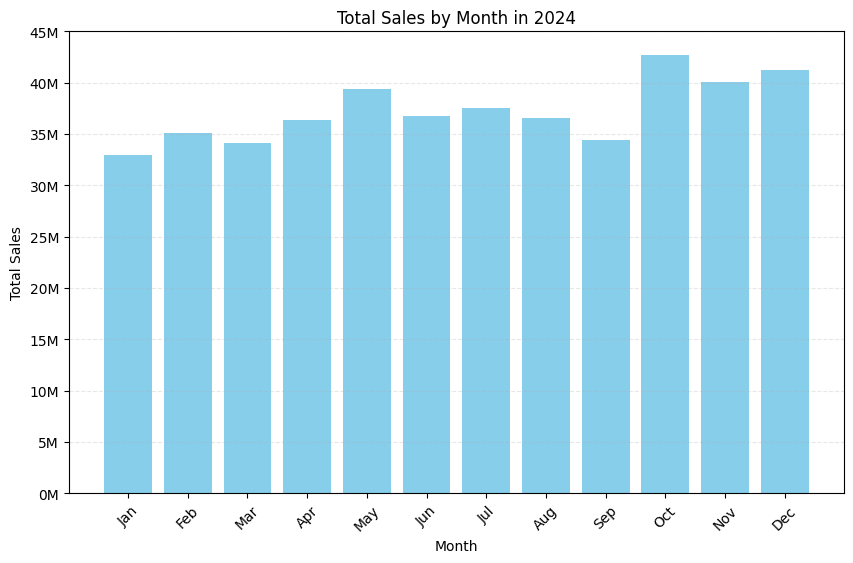

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(monthly_sales_trends_2024['month_name'], monthly_sales_trends_2024['total_sales'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month in 2024')
plt.xticks(rotation=45)
ax = plt.gca()
ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels([f'{int(x/1e6)}M' for x in ticks])
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show();

As we see in bar plot 3 last months (October, Novenber, December) were the most profitable in 2024

We also can discover total sales by month during 2022-2024 years to check the tendency over these 3 years

In [17]:
monthly_sales_trends_query = """
SELECT
  EXTRACT(YEAR FROM date) AS year,
  EXTRACT(MONTH FROM date) AS month,
  SUM(sale_dollars) AS total_sales
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
  EXTRACT(YEAR FROM date) IN (2022, 2023, 2024)
GROUP BY
  year, month
ORDER BY
  year, month;
"""

In [18]:
monthly_sales_trends = query_to_dataframe(monthly_sales_trends_query)
monthly_sales_trends['month_name'] = monthly_sales_trends['month'].apply(lambda x: calendar.month_abbr[x])

month_order = CategoricalDtype(
    categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ordered=True
)

monthly_sales_trends['month_name'] = monthly_sales_trends['month_name'].astype(month_order)

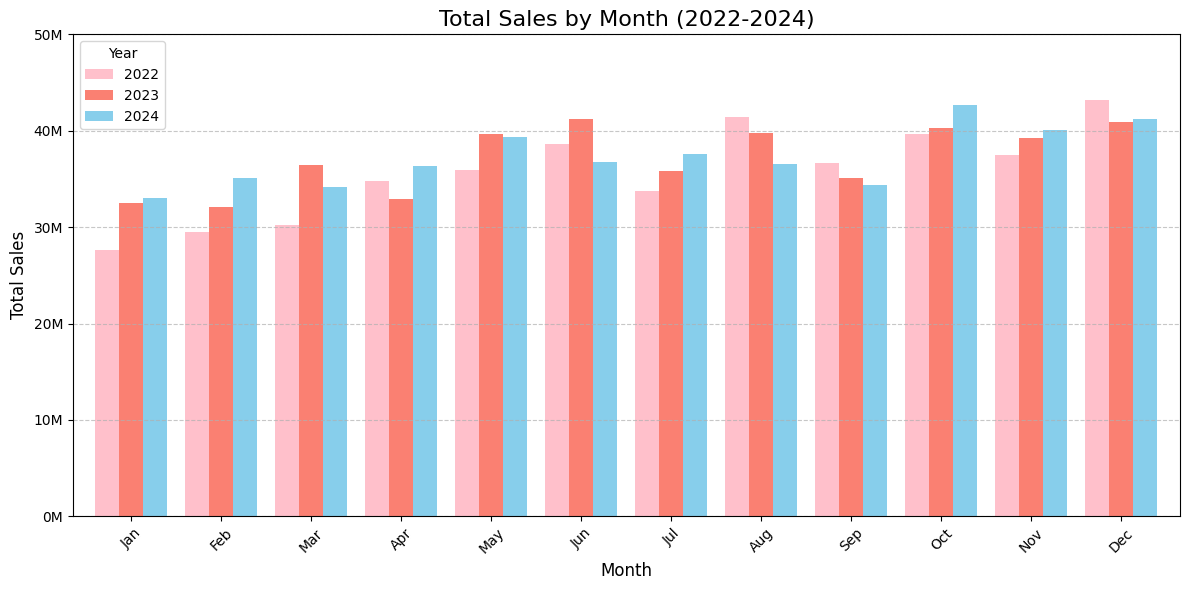

In [19]:
monthly_sales_trends_pivot = monthly_sales_trends.pivot(index='month_name', columns='year', values='total_sales')

monthly_sales_trends_pivot.plot(kind='bar', figsize=(12, 6), width=0.8, color=['pink', 'salmon', 'skyblue'])

plt.title('Total Sales by Month (2022-2024)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
ax = plt.gca()
ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels([f'{int(x/1e6)}M' for x in ticks])
plt.legend(title='Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

On the graph we see that the most profitable months:

2022 - August, October, December   
2023 - June, October, December   
2024 - October, November, December

For most months, sales in 2023 and 2024 are slightly higher than in 2022, indicating a potential year-over-year growth in sales.
The general monthly trend (peaks and valleys) is similar across all three years, suggesting consistent seasonal effects influencing sales.

In summary October and December were the most profitable months over the last 3 years, so we can assume that next year these months will be also the most profitable

Let's check top 10 cities by total sales over last 5 years (2020 - 2024) and their sales in each year

In [20]:
top_10_total_sales_city_query = """
SELECT
    EXTRACT(YEAR FROM date) AS year,
    city,
    SUM(sale_dollars) AS total_sales
FROM
    `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
    city IN (
        SELECT
            city
        FROM (
            SELECT
                city,
                SUM(sale_dollars) AS total_sales
            FROM
                `bigquery-public-data.iowa_liquor_sales.sales`
            WHERE
                EXTRACT(YEAR FROM date) BETWEEN 2020 AND 2024
            GROUP BY
                city
            ORDER BY
                total_sales DESC
            LIMIT 10
        )
    )
    AND EXTRACT(YEAR FROM date) BETWEEN 2020 AND 2024
GROUP BY
    year, city
ORDER BY
    year, total_sales DESC;
"""

In [21]:
top_10_total_sales_city_df = query_to_dataframe(top_10_total_sales_city_query)

top_10_total_sales_city_pt = top_10_total_sales_city_df.pivot_table(
    values='total_sales',
    index='city',
    columns='year',
    aggfunc='sum',
    fill_value=0
)

top_10_total_sales_city_pt

year,2020,2021,2022,2023,2024
city,,,,,
AMES,10863917.17,11660601.09,11154579.17,10652435.72,10311192.89
ANKENY,11082243.95,11255389.67,11720251.14,13099960.00,13756503.15
CEDAR RAPIDS,25986436.66,27401864.97,26790164.41,28132914.13,28616924.40
COUNCIL BLUFFS,13414214.76,14886989.90,14632003.92,15262970.59,15266595.86
DAVENPORT,21387615.38,21709074.12,20210618.18,20877394.74,20920750.46
DES MOINES,41781505.69,49521509.40,52362942.85,54637570.33,52826375.99
IOWA CITY,11184426.43,12491875.23,12727531.26,13135640.65,12856808.91
SIOUX CITY,12627089.01,13919343.37,13816975.04,14551499.48,14773532.44
WATERLOO,13249886.93,13886194.74,12886784.86,13190095.11,13173908.08


Also we can see the differences in sales in each year for these cities

In [22]:
growth_table = top_10_total_sales_city_pt.diff(axis=1).fillna(0)
growth_table

year,2020,2021,2022,2023,2024
city,,,,,
AMES,0.0,796683.92,-506021.92,-502143.45,-341242.83
ANKENY,0.0,173145.72,464861.47,1379708.86,656543.15
CEDAR RAPIDS,0.0,1415428.31,-611700.56,1342749.72,484010.27
COUNCIL BLUFFS,0.0,1472775.14,-254985.98,630966.67,3625.27
DAVENPORT,0.0,321458.74,-1498455.94,666776.56,43355.72
DES MOINES,0.0,7740003.71,2841433.45,2274627.48,-1811194.34
IOWA CITY,0.0,1307448.80,235656.03,408109.39,-278831.74
SIOUX CITY,0.0,1292254.36,-102368.33,734524.44,222032.96
WATERLOO,0.0,636307.81,-999409.88,303310.25,-16187.03


From this table we see that for some cities in growth in sales throughout all years, for others for some years was decreasing in sales

Let's also check heatmap for these cities

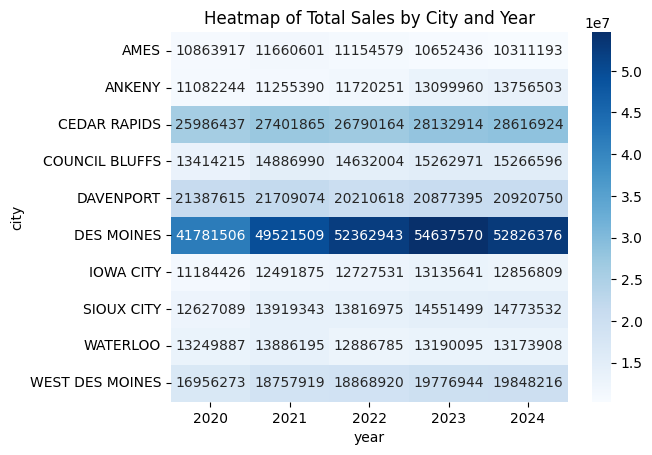

In [23]:
sns.heatmap(top_10_total_sales_city_pt, cmap='Blues', annot=True, fmt=".0f")
plt.title("Heatmap of Total Sales by City and Year")
plt.show()

Des Moines stands out with significantly higher total sales compared to other cities across all years. This indicates that Des Moines is likely the largest market for liquor sales in Iowa.

Most cities show a gradual increase in sales from 2020 to 2024

Now let's check best selled categories in 2023-2024 and compare them

In [24]:
top_10_category_sales_2023_query = """
SELECT
  category_name,
  SUM(sale_dollars) AS total_sales
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
  EXTRACT(YEAR FROM date) = 2023
GROUP BY
  category_name
ORDER BY
  total_sales DESC
LIMIT 10;
"""

In [25]:
top_10_category_sales_2023_df = query_to_dataframe(top_10_category_sales_2023_query)
top_10_category_sales_2023_df

,category_name,total_sales
0,AMERICAN VODKAS,67338842.37
1,CANADIAN WHISKIES,50361823.69
2,STRAIGHT BOURBON WHISKIES,38677699.67
3,100% AGAVE TEQUILA,32323236.84
4,WHISKEY LIQUEUR,26535647.13
5,SPICED RUM,23179414.50
6,TENNESSEE WHISKIES,16801219.22
7,IMPORTED CORDIALS & LIQUEURS,12501700.68
8,IMPORTED VODKAS,11971692.95
9,AMERICAN FLAVORED VODKA,11816546.34


In [26]:
top_10_category_sales_2024_query = """
SELECT
  category_name,
  SUM(sale_dollars) AS total_sales
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
  EXTRACT(YEAR FROM date) = 2024
GROUP BY
  category_name
ORDER BY
  total_sales DESC
LIMIT 10;
"""

In [27]:
top_10_category_sales_2024_df = query_to_dataframe(top_10_category_sales_2024_query)
top_10_category_sales_2024_df

,category_name,total_sales
0,AMERICAN VODKAS,67063063.21
1,CANADIAN WHISKIES,49826631.32
2,STRAIGHT BOURBON WHISKIES,40275195.32
3,100% AGAVE TEQUILA,34620858.60
4,WHISKEY LIQUEUR,26517447.81
5,SPICED RUM,22198681.63
6,TENNESSEE WHISKIES,16889224.49
7,TEMPORARY & SPECIALTY PACKAGES,16371280.32
8,IMPORTED CORDIALS & LIQUEURS,12000394.95
9,IMPORTED VODKAS,11898254.09


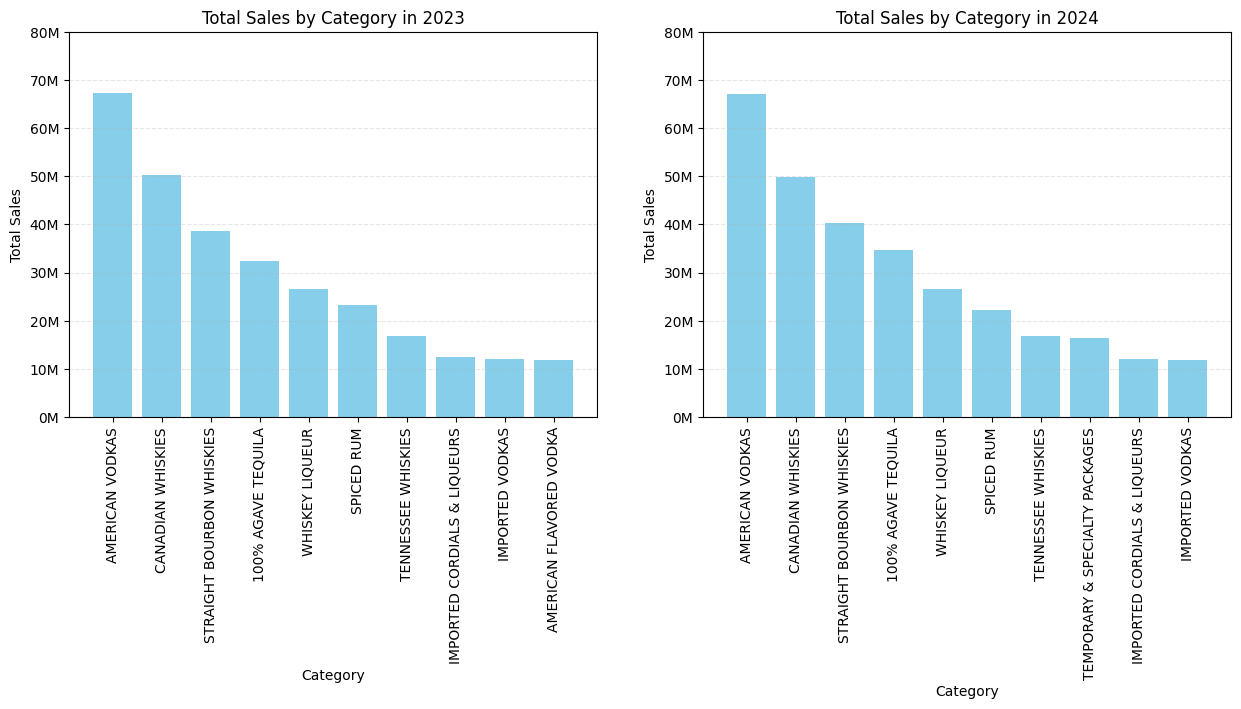

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(top_10_category_sales_2023_df['category_name'], top_10_category_sales_2023_df['total_sales'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Category in 2023')
plt.xticks(rotation=90)
ax = plt.gca()
ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels([f'{int(x/1e6)}M' for x in ticks])
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(top_10_category_sales_2024_df['category_name'], top_10_category_sales_2024_df['total_sales'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Category in 2024')
plt.xticks(rotation=90)
ax = plt.gca()
ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels([f'{int(x/1e6)}M' for x in ticks])
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show();

We can see that for last 2 years top selled categories are almost the same

The top-performing categories in both years include:  
American Vodkas  
Canadian Whiskies  
Straight Bourbon Whiskies  
  
Categories like American Flavored Vodka, Imported Cordials & Liqueurs, and Imported Vodkas consistently show lower total sales, indicating they are niche products.


In [29]:
sale_vs_volume_sold_liters_query = """
SELECT
  volume_sold_liters,
  sale_dollars
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
  EXTRACT(YEAR FROM date) = 2024
  AND volume_sold_liters IS NOT NULL
  AND volume_sold_liters > 0
  AND sale_dollars IS NOT NULL
  AND sale_dollars > 0
ORDER BY
  sale_dollars DESC;
"""

sale_vs_volume_sold_liters_df = query_to_dataframe(sale_vs_volume_sold_liters_query)
sale_vs_volume_sold_liters_df.head(10)

,volume_sold_liters,sale_dollars
0,13200.0,260832.0
1,13200.0,260832.0
2,13200.0,260832.0
3,13200.0,260832.0
4,6600.0,130416.0
5,5280.0,104332.8
6,1980.0,71280.0
7,1800.0,62976.0
8,3780.0,59918.4
9,810.0,50209.2


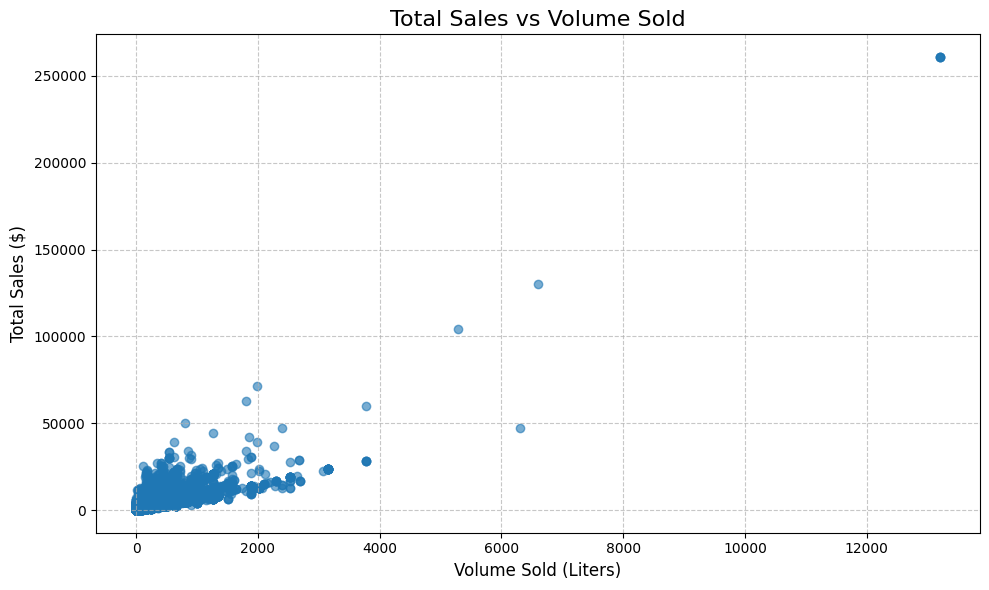

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(sale_vs_volume_sold_liters_df['volume_sold_liters'], sale_vs_volume_sold_liters_df['sale_dollars'], alpha=0.6)
plt.title('Total Sales vs Volume Sold', fontsize=16)
plt.xlabel('Volume Sold (Liters)', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Based on scatterplot we see that some values are significantly different (outliers). We can filter them using statistical techniques.

In [31]:
# Calculate the mean and standard deviation
mean_volume = sale_vs_volume_sold_liters_df['volume_sold_liters'].mean()
std_volume = sale_vs_volume_sold_liters_df['volume_sold_liters'].std()

volume_threshold = mean_volume + 2 * std_volume

filtered_sale_vs_volume_sold_liters_df = sale_vs_volume_sold_liters_df[sale_vs_volume_sold_liters_df['volume_sold_liters'] <= volume_threshold]

In [32]:
volume_threshold

88.59690520927278

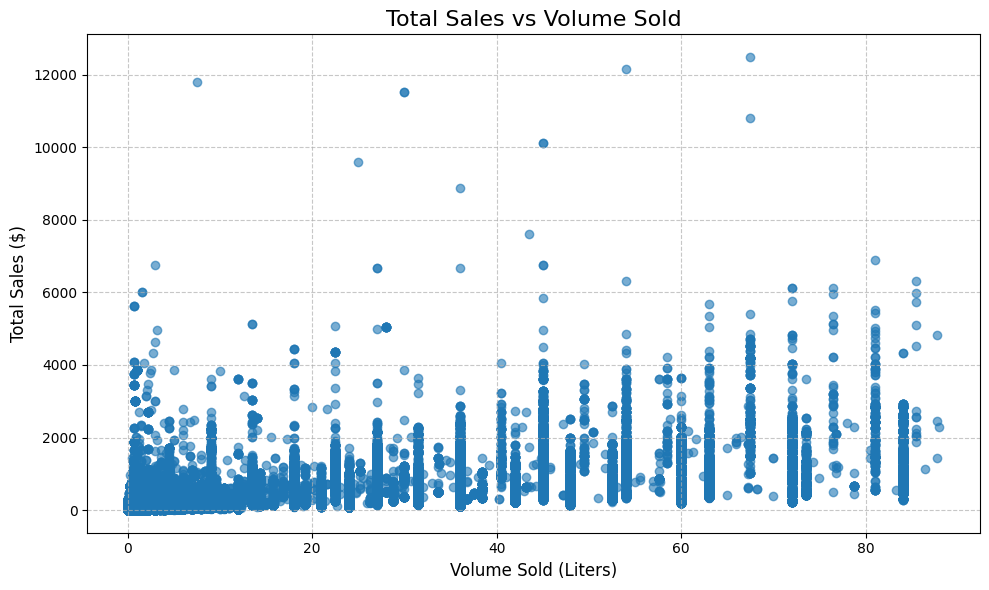

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(filtered_sale_vs_volume_sold_liters_df['volume_sold_liters'], filtered_sale_vs_volume_sold_liters_df['sale_dollars'], alpha=0.6)
plt.title('Total Sales vs Volume Sold', fontsize=16)
plt.xlabel('Volume Sold (Liters)', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Analyzing upper graph we see that majority of points are concentrated near the lower end of the x-axis (volume sold < 30 liters) and y-axis (total sales < 2000).
This can indicates that a significant number of transactions involve small volumes of liquor sold for lower total sales amounts.
There are a few points at higher y-values (e.g., total sales > 8000) with moderate or high volumes. These outliers might represent bulk purchases or expensive liquor products.

Let's investigate total sales dependency on season in 2024

In [34]:
season_total_sales_2024_query = """
SELECT
  CASE
    WHEN EXTRACT(MONTH FROM date) IN (12, 1, 2) THEN 'Winter'
    WHEN EXTRACT(MONTH FROM date) IN (3, 4, 5) THEN 'Spring'
    WHEN EXTRACT(MONTH FROM date) IN (6, 7, 8) THEN 'Summer'
    WHEN EXTRACT(MONTH FROM date) IN (9, 10, 11) THEN 'Autumn'
  END AS season,
  SUM(sale_dollars) AS total_sales
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
  EXTRACT(YEAR FROM date) = 2024
GROUP BY
  season
ORDER BY
  total_sales DESC;
"""

In [35]:
season_total_sales_2024_df = query_to_dataframe(season_total_sales_2024_query)

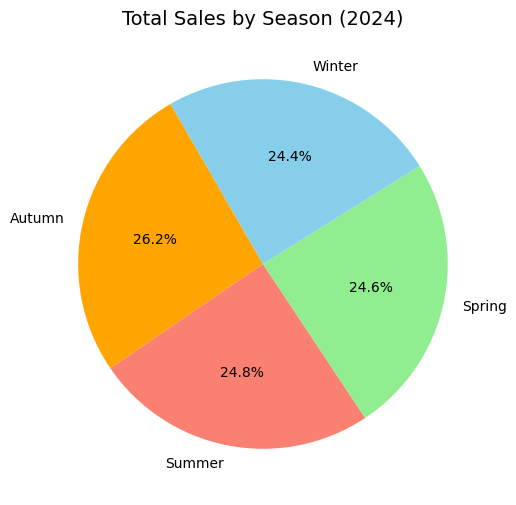

In [36]:
plt.figure(figsize=(6, 6))
plt.pie(
    season_total_sales_2024_df['total_sales'],
    labels=season_total_sales_2024_df['season'],
    autopct='%1.1f%%',
    startangle=120,
    colors=['orange', 'salmon', 'lightgreen', 'skyblue']
)
plt.title('Total Sales by Season (2024)', fontsize=14);

Sales are relatively evenly distributed across the four seasons, with no season dominating significantly.

The higher sales in Autumn might be linked to events like Thanksgiving, Halloween, and other holidays that drive liquor sales.

Despite including holiday periods like Christmas and New Year, Winter doesn't significantly outperform other seasons.

<div style="text-align: center"><h2>Key Insights</h2></div>


<b>City-Wise Performance:</b>

Des Moines consistently recorded the highest total sales across all years (2022–2024), followed by Cedar Rapids and Davenport.
Smaller cities like Ames and Iowa City show stable but lower contributions to overall sales.


<b>Category Analysis:</b>

American Vodkas dominated sales in both 2023 and 2024, significantly outperforming other categories.
Canadian Whiskies and Straight Bourbon Whiskies also ranked among the top-selling categories, indicating a strong preference for these products.


<b>Sales Volume vs. Revenue:</b>

The scatter plot revealed a non-linear relationship between volume_sold_liters and sale_dollars, with some high-revenue transactions having relatively low volumes. This indicates the presence of premium-priced liquor products.


<b>Seasonal Trends:</b>

Autumn (26.2%) contributed the highest proportion of sales in 2024, followed by Summer (24.8%), Spring (24.6%), and Winter (24.4%).
The seasonal distribution indicates balanced demand throughout the year, with slight peaks during Autumn and Summer.